### Testing out the new project

In [86]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

from src.clean import detect_na, standardize_columns, impute_nas
from src.eda import extended_describe, plot_correlation_heatmap, plot_dists, calc_vif, feat_select
from src.train import train_model
from src.tune import grand_tuner, param_spaces, dynamic_param_grid, save_best_params
from src.eval import eval_classification
from src.predict import load_trained_model, make_preds

from src.helper import save_best_params, load_best_params, serialize_params, stratified_sample, param_spaces, dynamic_param_grid

# df = pd.read_csv('../data/Breast_Cancer.csv')
df = pd.read_csv('../data/heart_attack_china.csv')

df

,Patient_ID,Age,Gender,Smoking_Status,Hypertension,Diabetes,Obesity,Cholesterol_Level,Air_Pollution_Exposure,Physical_Activity,...,Hospital_Availability,TCM_Use,Employment_Status,Education_Level,Income_Level,Blood_Pressure,Chronic_Kidney_Disease,Previous_Heart_Attack,CVD_Risk_Score,Heart_Attack
0,1,55,Male,Non-Smoker,No,No,Yes,Normal,High,High,...,Low,Yes,Unemployed,Primary,Low,104,Yes,No,78,No
1,2,66,Female,Smoker,Yes,No,No,Low,Medium,High,...,High,No,Unemployed,Secondary,Middle,142,No,No,49,No
2,3,69,Female,Smoker,No,No,No,Low,Medium,High,...,Low,No,Unemployed,Primary,High,176,No,No,31,No
3,4,45,Female,Smoker,No,Yes,No,Normal,Medium,Low,...,Medium,Yes,Employed,Primary,Low,178,No,Yes,23,No
4,5,39,Female,Smoker,No,No,No,Normal,Medium,Medium,...,Low,No,Retired,Higher,Middle,146,Yes,No,79,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239261,239262,53,Male,Non-Smoker,No,No,No,Normal,Medium,Medium,...,High,Yes,Retired,Higher,Low,167,No,No,86,Yes
239262,239263,48,Female,Non-Smoker,No,No,Yes,Normal,Low,Medium,...,Medium,Yes,Unemployed,Higher,Low,179,No,No,25,No
239263,239264,57,Male,Smoker,Yes,No,No,Normal,Low,High,...,Medium,Yes,Retired,Higher,Middle,136,No,No,89,No
239264,239265,42,Female,Non-Smoker,No,No,No,High,Medium,High,...,Low,Yes,Employed,Primary,Middle,159,No,No,72,Yes


### Cleaning and Preprocessing

In [87]:
detect_na(df)

,Columns,NA_count
0,Patient_ID,0
1,Age,0
2,Gender,0
3,Smoking_Status,0
4,Hypertension,0
5,Diabetes,0
6,Obesity,0
7,Cholesterol_Level,0
8,Air_Pollution_Exposure,0
9,Physical_Activity,0


Seems like it's mostly pristine, with one column, `Education_Level` needing to be removed.

In [88]:
df.drop(['Education_Level', 'Patient_ID'], axis='columns', inplace=True)


In [89]:
if df.isna().sum().sum() == 0: 
    print('No remaining NA vals')

No remaining NA vals


### EDA

In [90]:
# This will kick off a much larger discussion about that OHE (One Hot Encoding) and the drop_first=True argument
# It's undeniable that some information will be lost, but it can be re-created, no? 
# Yes, they can! It's tedious, but it can be done... then what's the harm? 
# Well, when there's hundreds or thousands of features, categorical reconstruction doesn't feel as feasible! 
# Exploring this concept more in a blog post; for now we'll just use get_dummies as usual

# df_encoded = pd.get_dummies(df, dtype=int, drop_first=True)


# from src.helper import map_target_column (maybe dosen't belong here but it belongs somwehere below)

df = standardize_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239266 entries, 0 to 239265
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   age                     239266 non-null  int64 
 1   gender                  239266 non-null  object
 2   smoking_status          239266 non-null  object
 3   hypertension            239266 non-null  object
 4   diabetes                239266 non-null  object
 5   obesity                 239266 non-null  object
 6   cholesterol_level       239266 non-null  object
 7   air_pollution_exposure  239266 non-null  object
 8   physical_activity       239266 non-null  object
 9   diet_score              239266 non-null  object
 10  stress_level            239266 non-null  object
 11  alcohol_consumption     239266 non-null  object
 12  family_history_cvd      239266 non-null  object
 13  healthcare_access       239266 non-null  object
 14  rural_or_urban          239266 non-n

In [ ]:
plot_correlation_heatmap(df)

In [93]:
summary_stats = extended_describe(df) 
summary_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,239266.0,59.466284,17.348308,30.0,44.0,59.0,75.0,89.0,0.002302,-1.204728
blood_pressure,239266.0,134.513378,25.991827,90.0,112.0,135.0,157.0,179.0,-0.001079,-1.201560
cvd_risk_score,239266.0,54.485581,25.987743,10.0,32.0,54.0,77.0,99.0,0.000369,-1.200624


In [97]:
calc_vif(df)

,Feature,VIF
0,age,9.330455
1,blood_pressure,10.881592
2,cvd_risk_score,4.867080


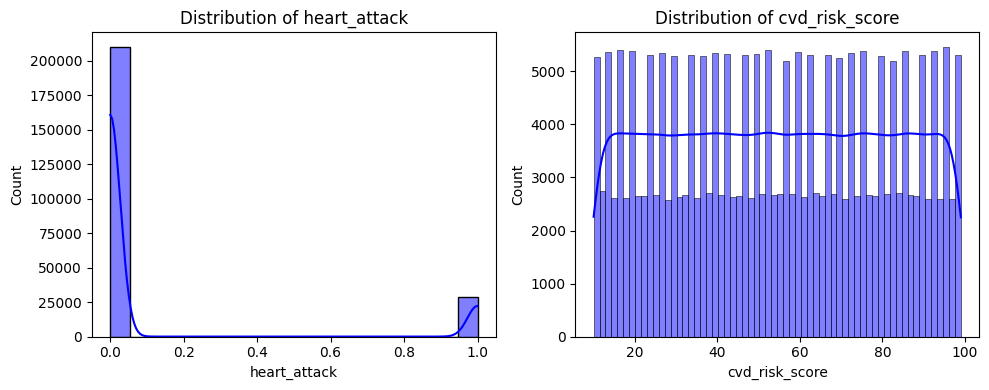

In [73]:
plot_dists(df, ['heart_attack', 'cvd_risk_score'])

### Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_encoded.drop(columns=['heart_attack_yes'])
y = df_encoded['heart_attack_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#-------------------
# SMOTE because unbalanced training data 
# smote = SMOTE(random_state=10)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# y_train.value_counts()

## Randomized Search --> GridSearch
Similar concept to using a Mixture Model to find optimal centroids, then plugging those same centroids into KMeans, which will run 100x faster. 

1. RandomizedSearchCV-- explores a broad parameter space without testing every single combination. It's the advance troops, narrowing down the scope  

2. GridSearchCV-- Focuses on the most promising regions found in step 1, fine-tuning the best params

In [ ]:
# March 21st-- 5:46pm

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time

# THIS IS INTENTIONALLY OUTSIDE
# Might make this global later, still deciding
param_spaces = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [50, 100, 200, 300, 500],
        "classifier__max_depth": [None, 10, 20, 30, 50],
        "classifier__min_samples_split": [2, 5, 10, 20],
        "classifier__min_samples_leaf": [1, 2, 5, 10],
        "classifier__max_features": ["sqrt", "log2", None]
    },
    "XGBClassifier": {
        "classifier__n_estimators": [50, 100, 200, 300],
        "classifier__max_depth": [3, 6, 9, 12],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__subsample": [0.5, 0.7, 1.0],
        "classifier__colsample_bytree": [0.5, 0.7, 1.0]
    },
    "LogisticRegression": {
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear", "saga"]
    }
}

def dynamic_param_grid(model, best_params):
    '''
    Refines hyperparameter search speace for GridSearchCV, based on model type
    
    Args:
        model: trained model object (RandomForest, XGBoost, LinearRegression)
        best_params: best paramters found from RandomizedSearchCV
        
    Returns:
        redefined_param_grid: param grid that is dependent on the `model`
    '''

    model_name = model.__class__.__name__
    if model_name not in param_spaces:
        raise ValueError(f"Model {model_name} is not yet supported by the `grand_tuner`.")
    
    refined_grid = {}

    try:
        # RF -- n_estimators and max_depth
        if model_name == "RandomForestClassifier":
            refined_grid = {
                "classifier__n_estimators": [
                    max(best_params["classifier__n_estimators"] - 50, 50),  
                    best_params["classifier__n_estimators"],  
                    best_params["classifier__n_estimators"] + 50
                ],
                "classifier__max_depth": [
                    best_params["classifier__max_depth"] - 10 if best_params["classifier__max_depth"] else None,
                    best_params["classifier__max_depth"],
                    best_params["classifier__max_depth"] + 10 if best_params["classifier__max_depth"] else None
                ]
            }
        
        # XGB -- n_estimators, learning_rate
        elif model_name == "XGBClassifier":
            refined_grid = {
                "classifier__n_estimators": [
                    max(best_params["classifier__n_estimators"] - 50, 50),  
                    best_params["classifier__n_estimators"],  
                    best_params["classifier__n_estimators"] + 50
                ],
                "classifier__learning_rate": [
                    max(best_params["classifier__learning_rate"] - 0.01, 0.01),
                    best_params["classifier__learning_rate"],
                    min(best_params["classifier__learning_rate"] + 0.01, 0.5)
                ]
            }

        # LR -- C, penalty
        elif model_name == "LogisticRegression":
            refined_grid = {
                "classifier__C": [
                    max(best_params["classifier__C"] / 10, 0.001),
                    best_params["classifier__C"],
                    min(best_params["classifier__C"] * 10, 1000)
                ],
                "classifier__penalty": [best_params["classifier__penalty"]] 
            }
    
    # If all else fails, revert to param_spaces (default) 
    except KeyError as e:
        print(f"⚠️ Missing expected param in best_params: {e}")
        print("Using default grid for fallback.")

        refined_grid = param_spaces[model_name]

    return refined_grid

#-------------------------------------------------------

def grand_tuner(model, param_grid, X, y, cv=5, scoring='roc_auc', use_smote=True, n_iter=20):
    '''
    Performs hyperparameter tuning using a two-step approach:
    1. RandomizedSearchCV to explore a broad parameter space
    2. GridSearchCV to fine-tune the best found region

    Args:
        model: the classifier to be tuned
        param_grid: dictionary of hyperparameters
        X: features
        y: target labels
        cv: number of Cross-Validation folds
        scoring: evaluation metric (roc_auc)
        use_smote: whether to apply SMOTE for class-balancing
        n_iter: number of iterations for RandomizedSearchCV (20)

    Returns: 
        best_model: model with optimal hyperparams
        best_params: dictionary of best hyperparams
    '''

    print(f"\nStarting Grand Tuner with {cv}-fold Cross-Validation...")
    print(f"Model: {model.__class__.__name__}")
    print(f"Scoring metric: {scoring}")
    print(f"SMOTE Enabled: {use_smote}")
    print(f"Running RandomizedSearchCV with {n_iter} iterations...")

    if param_grid is None:
        param_grid = param_spaces.get(model.__class__.__name__, {})
        print(f"Using default param grid for {model.__class__.__name__}: {param_grid}")

    # Pipeline with optional SMOTE
    steps = []
    if use_smote:
        steps.append(('smote', SMOTE(random_state=10)))

    steps.extend([('scaler', MinMaxScaler()), ('classifier', model)])
    pipeline = imbpipeline(steps)

    # Cross-validation strategy
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=10)

    # Step 1: RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=scoring,
        cv=stratified_kfold,
        n_jobs=-1,
        verbose=1,
        random_state=10
    )
   
    # Timing the Random Search
    start_random = time.time()
    random_search.fit(X, y)
    end_random = time.time()
    print(f"⏱️ RandomizedSearchCV completed in {(end_random - start_random)/60:.2f} minutes")


    # Get best parameters from RandomizedSearch
    best_random_params = random_search.best_params_
    print(f"\n🎲 Best Parameters from RandomizedSearch: {best_random_params}")

    refined_grid = dynamic_param_grid(model, best_random_params)
    print(f"\n🛠️ Running GridSearchCV with refined parameters: {refined_grid}")

    # Step 2: GridSearchCV 
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=refined_grid, 
        scoring=scoring, 
        cv=stratified_kfold, 
        n_jobs=4, 
        verbose=1
    ) 

    # Timing the Grid Search
    start_grid = time.time()
    grid_search.fit(X, y)
    end_grid = time.time()
    print(f"⏱️ GridSearchCV completed in {(end_grid - start_grid)/60:.2f} minutes")


    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    cv_results = grid_search.cv_results_

    print("=" * 50)
    print(f"\n✅ Best Model Found: {best_model}")
    print(f"🏆 Best Hyperparameters: {best_params}")
    print(f"📊 Best {scoring}: {grid_search.best_score_:.4f}")

    return best_model, best_params, cv_results

## TESTING THE GRAND TUNER

In [17]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=10)

# Pass None to use default grid from param_spaces
best_model, best_params, cv_results = grand_tuner(
    model=rf_model,
    param_grid=None,  # Uses default
    X=X,
    y=y,
    cv=2,  # Start small
    scoring='roc_auc',
    use_smote=True,
    n_iter=2  # Start small, scale later
)


Starting Grand Tuner with 2-fold Cross-Validation...
Model: RandomForestClassifier
Scoring metric: roc_auc
SMOTE Enabled: True
Running RandomizedSearchCV with 2 iterations...
Using default param grid for RandomForestClassifier: {'classifier__n_estimators': [50, 100, 200, 300, 500], 'classifier__max_depth': [None, 10, 20, 30, 50], 'classifier__min_samples_split': [2, 5, 10, 20], 'classifier__min_samples_leaf': [1, 2, 5, 10], 'classifier__max_features': ['sqrt', 'log2', None]}
Fitting 2 folds for each of 2 candidates, totalling 4 fits
⏱️ RandomizedSearchCV completed in 22.18 minutes

🎲 Best Parameters from RandomizedSearch: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None, 'classifier__max_depth': 50}
🛠️ Running GridSearchCV with refined parameters: {'classifier__n_estimators': [450, 500, 550], 'classifier__max_depth': [40, 50, 60]}
Fitting 2 folds for each of 9 candidates, totalling 18 fits
⏱️ Grid

In [53]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'RandomForest': (RandomForestClassifier, {'class_weight':'balanced'}),
    'XGBoost': (XGBClassifier, None)
}

trained_models = train_model(X_train, y_train, models)

# Accessing the trained model:
rf_model = trained_models['RandomForest']
xgb_model = trained_models['XGBoost']

Training Models...
Training RandomForest(RandomForestClassifier) with params: {'class_weight': 'balanced'}...
✅ RandomForest training complete! Model saved to ../models\RandomForest.pkl

Training XGBoost(XGBClassifier) with params: default settings...
✅ XGBoost training complete! Model saved to ../models\XGBoost.pkl



# Now Testing `tune_and_train_full()`

In [ ]:
from src.helper import map_target_column


df['heart_attack'] = map_target_column(df, 'heart_attack', 
                                       positive='Yes', 
                                       negative='No')  

df['heart_attack']

0         0
1         0
2         0
3         0
4         0
         ..
239261    1
239262    0
239263    0
239264    1
239265    0
Name: heart_attack, Length: 239266, dtype: int64

### DATA LEAKAGE FIX ONGOING
1. Split raw data 
2. Fit new encoder on X_train_raw -- transform both train and test
3. Run `feat_select` on encoded X_train 
4. Apply selected features to both X_train and X_test. 

In [ ]:
# Testing here: 
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import StratifiedKFold


def feat_select(df_encoded: pd.DataFrame, target, smote_enabled=True, imbal_thresh=0.15):
    '''
    Feature selection using ElasticNetCV on an encoded (quickly with get_dummies) df

    Returns: 
        selected: List of selected feature names
    '''

    X = df_encoded.drop(columns=[target])
    y = df_encoded[target]

    # Check for imbalance
    class_counts = y.value_counts(normalize=True) 
    min_class_ratio = class_counts.min()

    if smote_enabled and min_class_ratio < imbal_thresh: 
        print(f"⚠️ Imbalanced data detected ({min_class_ratio:.2%}). Applying SMOTE...\n")
        X, y = SMOTE(random_state=10).fit_resample(X, y) 

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X) 

    min_alpha = 1e-7 * abs((X_scaled.T @ y)).mean()

    elastic_model = ElasticNetCV(
        alphas = pd.Series(np.geomspace(min_alpha, min_alpha*100, 50)), 
        l1_ratio=0.6 if smote_enabled else [0.1, 0.5, 0.9],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10),
        random_state=10
        ) 
    
    elastic_model.fit(X_scaled, y)

    selected = X.columns[elastic_model.coef_ != 0].tolist()

    print("📌 ElasticNet Feature Selection Summary")
    print("======================================")
    print(f"SMOTE enabled: {smote_enabled}")
    print(f"Selected feature count: {len(selected)} (🔻{X.shape[1] - len(selected)} trimmed)")
    print(f"Best Alpha: {elastic_model.alpha_:.2e}")
    print(f"Best L1 Ratio: {elastic_model.l1_ratio_:.2f}")
    print("======================================\n")

    return selected

In [21]:
temp_encoded = pd.get_dummies(df, drop_first=True, dtype=int)

In [101]:
selected_feats = feat_select(temp_encoded, 'heart_attack', True)

⚠️ Imbalanced data detected 
(Minority class = 12.15%) 
Applying SMOTE...

ElasticNet Feature Selection Summary
SMOTE enabled
Original feature count: 43
Selected feature count: 40 (🔻3 trimmed)
Best Alpha: 4.17e-03
Best L1 Ratio: 0.60
Final Selected Features:
['gender_Male', 'smoking_status_Smoker', 'hypertension_Yes', 'diabetes_Yes', 'obesity_Yes', 'cholesterol_level_Low', 'cholesterol_level_Normal', 'air_pollution_exposure_Low', 'air_pollution_exposure_Medium', 'physical_activity_Low', 'physical_activity_Medium', 'diet_score_Moderate', 'diet_score_Poor', 'stress_level_Low', 'stress_level_Medium', 'alcohol_consumption_Yes', 'family_history_cvd_Yes', 'healthcare_access_Moderate', 'healthcare_access_Poor', 'rural_or_urban_Urban', 'region_Eastern', 'region_Northern', 'region_Southern', 'region_Western', 'province_Gansu', 'province_Guangdong', 'province_Henan', 'province_Qinghai', 'province_Shandong', 'province_Shanghai', 'province_Sichuan', 'hospital_availability_Low', 'hospital_availabil

March 28th-- 6:29pm

Currently broken, because `feat_select` can't handle unencoded features. Working on a fix, still coming

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# # Step 1: Split BEFORE encoding!
X = df.drop(columns=['heart_attack'])
y = df['heart_attack']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=10) 

# Step 2: Fit OHE only on training!
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train_raw) 
X_test_encoded = ohe.fit_transform(X_test_raw) 

# Now back to DataFrames with col names: 
encoded_cols = ohe.get_feature_names_out(X_train_raw.columns) 
X_train = pd.DataFrame(X_train_encoded, columns=encoded_cols)
X_test = pd.DataFrame(X_test_encoded, columns=encoded_cols)


# Comment / uncomment for testing if this actually helps
# ======================================================
X_train = X_train[selected_feats]
X_test = X_test[selected_feats]


In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from src.run_pipeline import tune_and_train_full


logit_model, best_params = tune_and_train_full(
    model_class=LogisticRegression,
    model_name='Logit',
    X_train=X_train,
    y_train=y_train,
    # model_params={'class_weight': 'balanced'},
    # model_params = None,
    X_test=X_test,
    y_test=y_test,
    sample_frac=0.2, 
    scoring='roc_auc',
    use_smote=True,
    n_iter=20, 
    cv=5,
    dev_mode=False 
)

🔍 Sampled 38282 rows (20.0%)
Class distribution:
heart_attack
0    33631
1     4651

Starting Grand Tuner | CV: 5 | Scoring: roc_auc
Model: LogisticRegression | SMOTE: True | Random Iterations: 20

**LogisticRegression param grid is None, using default

Fitting 5 folds for each of 20 candidates, totalling 100 fits
⏱️ RandomizedSearchCV completed in 0.22 minutes

Fitting 5 folds for each of 3 candidates, totalling 15 fits
⏱️ GridSearchCV completed in 0.07 minutes

🏆 Best Hyperparameters: {
  "classifier__solver": "liblinear",
  "classifier__penalty": "l1",
  "classifier__C": 0.001
}

📊 Best roc_auc: 0.5000
💾 Saved best params for LogisticRegression to ../tuned_params\LogisticRegression_best_params.json


[TRAINING] Starting model training...

→ Training Logit with params:
{
    "classifier__solver": "liblinear",
    "classifier__penalty": "l1",
    "classifier__C": 0.001
}

✅ Logit trained | Saved to ../models\Logit.pkl

 Running evaluation on test set...
⚠️ Imbalanced test set detected

c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

## Plotting Threshold Curves

Helper Function, here temporarily.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from collections import Counter

def find_best_threshold(y_true, y_probs, metric='f1', plot=True):
    '''
    Finds optimal classification thresh for a given metric (defauly f1)

    Args: 
        y_true: Ground truth binary labels
        y_probs: Predicted probs for target class
        metric: f1 
        plot: Whether to plot the metric vs thresh curve

    Returns: 
        best_thresh: Thresh that maximizes f1
    '''

    thresholds = np.linspace(0.0, 1.0, 100)
    scores = []

    # Determining minority class:
    class_counts = Counter(y_true)
    minority_class = min(class_counts, key=class_counts.get) 

    for t in thresholds: 
        y_pred = (y_probs >= t).astype(int) 
        score = f1_score(y_true, y_pred, pos_label=minority_class, average='binary', zero_division=0) 
        scores.append(score)

    best_idx = np.argmax(scores)
    best_thresh = thresholds[best_idx]

    # Warn if threshold is extremely low or high
    if best_thresh < 0.05 or best_thresh > 0.95:
        print(f"⚠️ Warning: Best threshold is at extreme value: {best_thresh:.3f}. Check model calibration.")

    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thresholds, scores, label=f'{metric} score') 
        plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best threshold = {best_thresh:.2f}')
        plt.xlabel('Threshold') 
        plt.ylabel(f'{metric.upper()} Score')
        plt.title(f'{metric.upper()} vs Threshold')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show() 

    return best_thresh

Once tested, getting sent to `eval.py` -- remember to copy this version over! Also remember to get all the imports ready!!!

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

# from src.eval import find_best_threshold 

# Potting the Threshold Curves
def plot_threshold_curves(y_true, y_probs, model_name='Model', highlight_threshold=0.25, save_path=None, auto_find_best=True, metric='f1'):
    '''
    Plots the ROC and Precision-Recall curves with optional annotations

    Args: 
        y_true: Ground truth binary labels
        y_probs: Predicted probs of the positive class
        model_name: Name of the model (used for labels!)
        highlight_threshold: Optional thresh to annotate on both curves
        save_path: Optional filepath to save the plots
        auto_find_best: if True, auto finds the best thresh based on chosen metric
        metric: Metric to optimize (f1 or recall) 

    Returns: 
        threshold_to_plot: The thresh tht was highlighted (auto or manual) 
    '''

    # Decide which thresh to highlight
    if auto_find_best: 
        highlight_threshold = find_best_threshold(y_true, y_probs, metric=metric, plot=True)

    # Roc Data
    # fpr -- False Positive Rate 
    # tpr -- True Positive Rate
    # roc_thresholds -- differing threshs used to generated fpr, tpr pairs :D 

    # auc(fpr, tpr) calcs total area under the ROC curve.
    # This is the model's ability to discriminate between classes

    # Reminder: Area Under Curve (AUC) 
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr) 

    # PR Data
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)

    # Find closest index to thresh_to_plot
    idx_roc = np.argmin(np.abs(roc_thresholds - highlight_threshold))
    idx_pr = np.argmin(np.abs(pr_thresholds - highlight_threshold)) 

    # Plot
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

    # ROC Curve
    ax1.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax1.plot([0,1], [0,1], linestyle='--', color='gray') # Represents random classification (FPR = TPR)
    ax1.scatter(fpr[idx_roc], tpr[idx_roc], color='red', label=f'Thresh = {round(highlight_threshold, 3)}')
    ax1.set_title(f'ROC Curve - {model_name}')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Raet') 
    ax1.legend()

    ax2.plot(recall, precision, label=f'AUC = {pr_auc:.2f}') 
    ax2.scatter(recall[idx_pr], precision[idx_pr], color='red', label=f'Thresh = {round(highlight_threshold, 3)}')
    ax2.set_title(f'Precision-Recall Curve - {model_name}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision') 
    ax2.legend()

    fig.suptitle(f"Threshold Analysis for {model_name}", fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f'Plot saved to {save_path}')
    
    plt.show() 
    
    return round(highlight_threshold, 3)


⚠️ Warning: Best threshold is at extreme value: 0.000. Check model calibration.


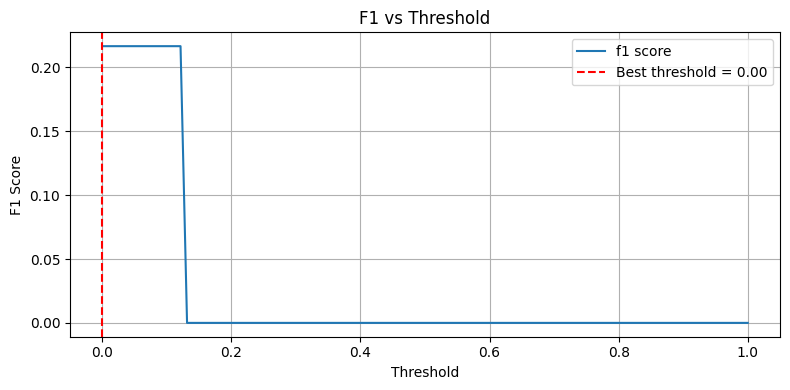

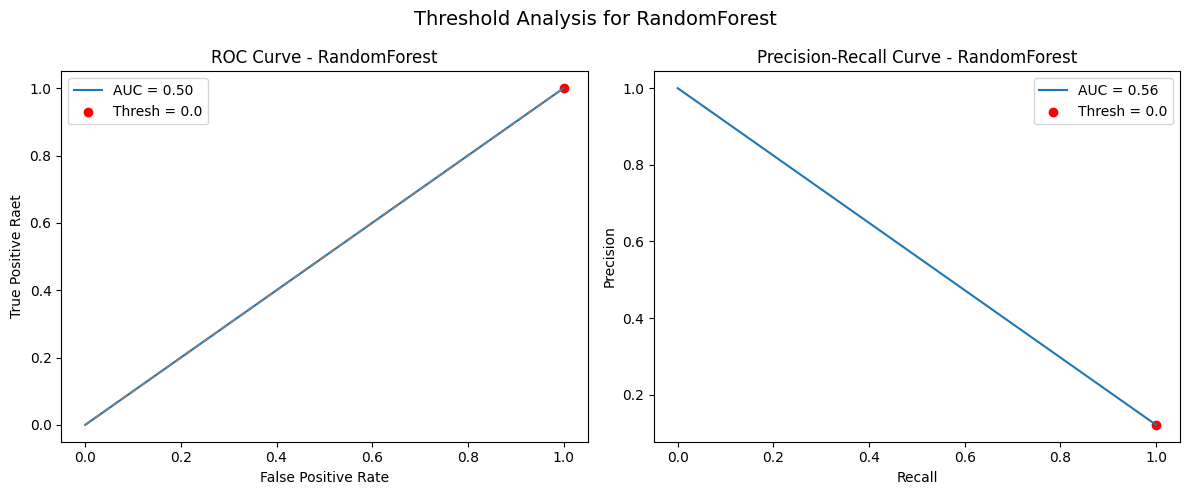

np.float64(0.0)

In [105]:
# from src.eval import plot_threshold_curves

y_probs_rf = rf_model.predict_proba(X_test)[:,1] 
y_probs_logit = logit_model.predict_proba(X_test)[:,1]

# Plotting ROC and PR Curves:
plot_threshold_curves(y_test, y_probs_logit, "RandomForest", auto_find_best=True)

Testing `eval_classification` with the new thresh (which we just found) 

In [35]:
eval_classification(rf_model, X_test, y_test, threshold=0.172)


🔧 Custom threshold applied: 0.172

Evaluating Model: RandomForestClassifier
Hyperparameters:
{
    "bootstrap": true,
    "ccp_alpha": 0.0,
    "class_weight": "balanced",
    "criterion": "gini",
    "max_depth": null,
    "max_features": null,
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_samples_leaf": 10,
    "min_samples_split": 5,
    "min_weight_fraction_leaf": 0.0,
    "monotonic_cst": null,
    "n_estimators": 350,
    "n_jobs": null,
    "oob_score": false,
    "random_state": null,
    "verbose": 0,
    "warm_start": false
}

Overall Metrics:
| Metric             |   Score |
|:-------------------|--------:|
| Accuracy           |  0.1215 |
| Weighted Precision |  0.8933 |
| Weighted Recall    |  0.1215 |
| Weighted F1-Score  |  0.0264 |

Class-Specific Metrics:
|   Class |   Precision |   Recall |   F1-Score |   Support |
|--------:|------------:|---------:|-----------:|----------:|
|       0 |      1      |        0 |     0

In [42]:
X_train.describe()
X_train.corrwith(y_train).sort_values(ascending=False)

family_history_cvd_Yes           0.007467
region_Southern                  0.004744
province_Shandong                0.004136
province_Guangdong               0.003364
previous_heart_attack_Yes        0.003258
province_Henan                   0.003153
air_pollution_exposure_Low       0.003058
physical_activity_Medium         0.002789
region_Northern                  0.002563
smoking_status_Smoker            0.002499
employment_status_Retired        0.002303
healthcare_access_Poor           0.002247
gender_Male                      0.002042
alcohol_consumption_Yes          0.001823
hospital_availability_Low        0.001605
hospital_availability_Medium     0.001318
hypertension_Yes                 0.001231
income_level_Middle              0.001146
chronic_kidney_disease_Yes       0.001132
cholesterol_level_Normal         0.000888
province_Gansu                   0.000691
cholesterol_level_Low            0.000583
stress_level_Low                 0.000476
region_Eastern                  -0

In [58]:
model = rf_model.named_steps['model']
importances = pd.Series(model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(10))

gender_Male                      0.041132
smoking_status_Smoker            0.041086
tcm_use_Yes                      0.036648
rural_or_urban_Urban             0.033272
air_pollution_exposure_Medium    0.033014
hospital_availability_Low        0.031582
cholesterol_level_Normal         0.031194
hospital_availability_Medium     0.031022
healthcare_access_Poor           0.030862
diet_score_Poor                  0.030608
dtype: float64


In [60]:
y_train.value_counts(normalize=True)


heart_attack
0    0.878498
1    0.121502
Name: proportion, dtype: float64